In [0]:
import numpy as np
from PIL import Image
import os
import string
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from torchvision import models, datasets, transforms

Skip these lines if not using Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!mkdir project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/captioning.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/dataset.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/model.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/utils.py' project
!cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/datasets' project
# !cp -r 'drive/My Drive/Colab Notebooks/small projects/image-captioning/embedding' project

mkdir: cannot create directory ‘project’: File exists


In [0]:
cd project

/content/project


Import all necessary functions

In [0]:
from utils import get_captions, get_embedding_dict, get_embedding_matrix, get_images_list, get_padded_captions, encode_captions
from dataset import CaptioningDataset
from model import Decoder, Encoder
from captioning import Captioning

In [0]:
from zipfile import ZipFile
with ZipFile('datasets/Flickr8k_Dataset.zip') as zipObj:
    zipObj.extractall('datasets')
with ZipFile('datasets/Flickr8k_text.zip') as zipObj:
    zipObj.extractall('datasets')

Get GloVe embedding vectors, skip this lines if you prefer not to use pretrained embedding weights

In [0]:
# embedding_dict = get_embedding_dict('embedding/glove.6B.100d.txt')

## Loading data files
Get list of training images by running `get_images_list()` function

In [0]:
train_images = get_images_list('datasets/Flickr_8k.trainImages.txt')
train_images[:3]

['2513260012_03d33305cf.jpg',
 '2903617548_d3e38d7f88.jpg',
 '3338291921_fe7ae0c8f8.jpg']

Get dictionary of training captions mapping to each images, using `get_captions()`

In [0]:
train_captions = get_captions('datasets/Flickr8k.token.txt', train_images)
train_captions['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow  <END>',
 '<START> black dog chasing brown dog through snow <END>',
 '<START> two dogs chase each other across the snowy ground  <END>',
 '<START> two dogs play together in the snow  <END>',
 '<START> two dogs running through a low lying body of water  <END>']

Get padded version of captions and return maximum training captions' length, using `get_padded_captions()`

In [0]:
train_captions_padded, max_length = get_padded_captions(train_captions)
train_captions_padded['2513260012_03d33305cf.jpg']

['<START> a black dog is running after a white dog in the snow  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> black dog chasing brown dog through snow <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs chase each other across the snowy ground  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs play together in the snow  <END> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>',
 '<START> two dogs running through a low lying body of water  <END> <PAD> <PAD> <PAD> <PAD> 

Get word2idx and idx2word, with vocabulary size

In [0]:
word_to_idx, idx_to_word, vocab_size = encode_captions(train_captions_padded)
print('First 5 elements of idx_to_word: ', idx_to_word[:5])
print('word_to_idx of <PAD>: ',word_to_idx['<PAD>'])

First 5 elements of idx_to_word:  ['<START>', '<END>', '<PAD>', 'a', 'child']
word_to_idx of <PAD>:  2


Our training vocab size

In [0]:
vocab_size

7633

In this notebook, I don't use pretrained weights from GloVe, so I commented below line

In [0]:
# embedding_matrix = get_embedding_matrix(idx_to_word, embedding_dict)

Create custom DataSet and DataLoader classes

In [0]:
dataset = CaptioningDataset('datasets/Flicker8k_Dataset', train_captions_padded, word_to_idx)

In [0]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

## Create model

In [0]:
encoder = Encoder()
decoder = Decoder(False, vocab_size=vocab_size, embed_dim=256)

In [0]:
criterion = nn.CrossEntropyLoss()
# params = list(decoder.lstm.parameters()) + list(decoder.linear.parameters())
params = list(decoder.parameters())
optimizer = Adam(params)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)

In [0]:
captioning = Captioning(encoder, decoder, criterion, optimizer, 5, scheduler, 100)

### Train time

In [0]:
captioning.train(dataloader)

Epoch 0
--------
Iter 0: loss = 8.881195
Iter 100: loss = 1.228447
Iter 200: loss = 1.114627
Epoch 1
--------
Iter 0: loss = 0.946724
Iter 100: loss = 0.918332
Iter 200: loss = 0.969621
Epoch 2
--------
Iter 0: loss = 0.783856
Iter 100: loss = 0.632871
Iter 200: loss = 0.670220
Epoch 3
--------
Iter 0: loss = 0.604097
Iter 100: loss = 0.631996
Iter 200: loss = 0.673547
Epoch 4
--------
Iter 0: loss = 0.592749
Iter 100: loss = 0.520127
Iter 200: loss = 0.550950


In [0]:
# save state dict
captioning.save_state_dict('state_dict.pth')
!cp state_dict.pth '../drive/My Drive/Colab Notebooks/small projects/image-captioning/saved_model'

### Test time
I use Beam search at test time, in which `k` is the number of beams we want to use

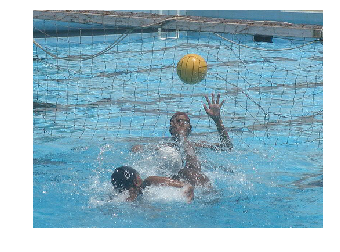

Generated caption:  two children playing in a pool with a ball


In [0]:
captioning.generate_caption('datasets/Flicker8k_Dataset/3621717946_d96f8a6012.jpg', word_to_idx, idx_to_word, max_length, True, k=3)

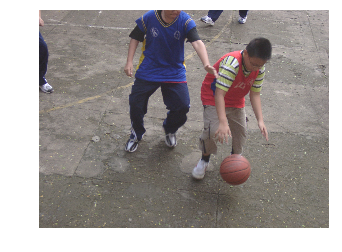

Generated caption:  a little boy in a blue shirt is chasing a soccer ball on the ground


In [0]:
captioning.generate_caption('datasets/test_images/02040007.JPG', word_to_idx, idx_to_word, max_length, True, k=3)